<a href="https://colab.research.google.com/github/robinanwyl/oud_transcriptomics/blob/main/BENG204_Project_SingleCell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 204 Project: Understanding Transcriptional Responses to Opioid Exposure Across Neurodevelopmental Stages in Brain Organoid Models - Single Cell Analysis

# Notebook setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install scanpy
%pip install anndata
%pip install igraph
%pip install harmonypy
%pip install symphonypy
%pip install pydeseq2
%pip install decoupler==1.8.0
%pip install gseapy==1.1.6
%pip install marsilea

In [302]:
%pip install adjustText

In [3]:
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import numpy as np
import pandas as pd
import symphonypy as sp
import decoupler as dc
from scipy.stats import median_abs_deviation
import gc
import random
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp

# Kim d53 samples - Data read-in

**Read in the scRNA-seq data for Kim et al dataset day 53 untreated sample and day 53 acute fentanyl treatment sample, add metadata and prepend cell barcodes with unique identifiers, and save each sample as a separate `.h5ad.gz` file. Then merge the datasets and save the merged dataset as a `h5ad.gz` file as well.**

The original sample IDs are KH001 for the day 53 untreated sample and KH002 for the day 53 acute fentanyl treatment sample. Each sample has its own folder containing 3 compressed (`.gz`) files, which are the 10X Genomics CellRanger output files:

*   `matrix.mtx.gz` is a count matrix where rows are single cells, columns are genes, and each cell is the read count of that gene in that cell
*   `barcodes.tsv.gz` contains the cell barcodes (each cell is labeled with a unique barcode, which is used as an identifier)
*   `features.tsv.gz` contains the gene names

For each of the 2 samples, we will first use `scanpy.read_10x_mtx()` to read the 3 files into a single `AnnData` object that contains the cell-by-gene matrix and associated metadata (`obs` = barcodes, `var` = features). We will add columns to the `obs` attribute, `Sample` indicating the sample name and `condition` indicating the treatment group of the sample (untreated or fentanyl). In preparation for merging these samples into one `AnnData` object later, we will prepend the cell barcodes with a sample description, "d53_ut" for untreated samples and "d53_fty" for treated samples. Then we will save each sample `AnnData` object as a compressed `.h5ad.gz` file for later use.

In [ ]:
sample1_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH001_Day53_Untreated"
adata1 = sc.read_10x_mtx(sample1_path, var_names="gene_symbols", cache=True)
adata1.obs["Sample"] = "kim_day53_untreated"
adata1.obs["condition"] = "d53_untreated"
adata1.obs.index = [f"d53_ut_{barcode}" for barcode in adata1.obs.index]
adata1.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ut.h5ad.gz", compression="gzip")

sample2_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH002_Day53_FTY_Acute"
adata2 = sc.read_10x_mtx(sample2_path, var_names="gene_symbols", cache=True)
adata2.obs["Sample"] = "kim_d53_fty_acute"
adata2.obs["condition"] = "d53_fty_acute"
adata2.obs.index = [f"d53_fty_{barcode}" for barcode in adata2.obs.index]
adata2.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_fty.h5ad.gz", compression="gzip")

In [ ]:
adata_combined = sc.concat([adata1, adata2], label="orig_sample", keys=["sample1", "sample2"])
adata_combined.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz", compression="gzip")

In [ ]:
del adata1, adata2, adata_combined
gc.collect()

9955

# Kim d53 samples - QC

Read in combined d53 dataset

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz")

Store raw counts and save file

In [ ]:
kim_d53.raw = kim_d53.copy()
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz", compression="gzip")

We will begin QC by calculating common QC metrics with `scanpy.pp.calculate_qc_metrics()`. We will also label mitochondrial, ribosomal, and hemoglobin genes.

In [ ]:
def qc_metrics(adata):
  # mitochondrial genes, "MT-" for human, "Mt-" for mouse
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
  # ribosomal genes
  adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
  # hemoglobin genes
  adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)

qc_metrics(kim_d53)

Inspect plots

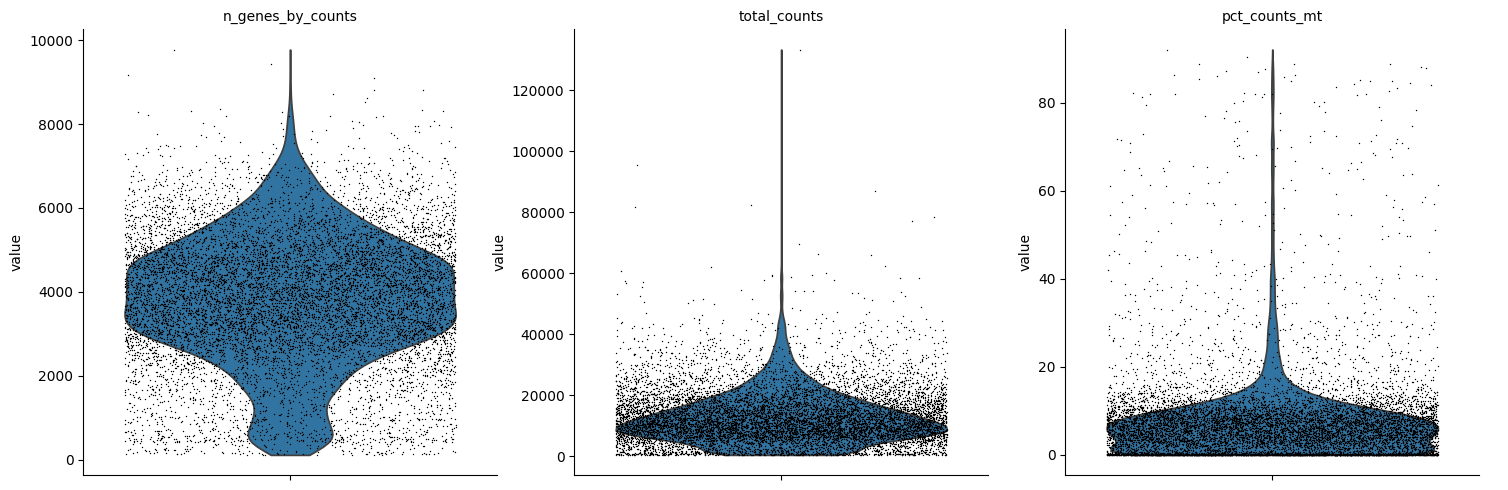

In [ ]:
sc.pl.violin(
    kim_d53,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

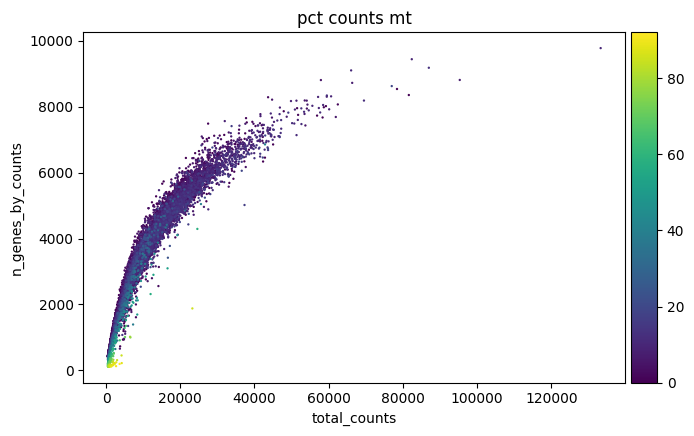

In [ ]:
sc.pl.scatter(kim_d53, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

To filter out low-quality cells, we will use automatic thresholding via MAD (median absolute deviations) following the [Single-Cell Best Practices](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) tutorial. We will mark cells as outliers if they differ by 3 MADs. For filtering out cells with a high percentage of mitochondrial genes, we will use 3 MADs. We will also manually set a threshold to filter out cells with >20% mitochondrial genes, consistent with brain organoid transcriptomic studies [Vertesy et al (2022)](https://www.embopress.org/doi/full/10.15252/embj.2022111118) and [Fleck et al (2023)](https://www.nature.com/articles/s41586-022-05279-8).

In [ ]:
def assign_outliers(adata):
  def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

  adata.obs["outlier"] = (
      is_outlier(adata, "log1p_total_counts", 3)
      | is_outlier(adata, "log1p_n_genes_by_counts", 3)
      | is_outlier(adata, "pct_counts_in_top_20_genes", 3)
      | is_outlier(adata, "pct_counts_mt", 3)
      | (adata.obs["pct_counts_mt"] > 20)
  )

assign_outliers(kim_d53)
kim_d53.obs.outlier.value_counts()

,count
outlier,
False,8631
True,1999


Apply thresholds

In [ ]:
kim_d53 = kim_d53[~kim_d53.obs.outlier].copy()

We will save the `AnnData` object with the cell barcodes and genes that passed QC as a `.h5ad.gz` file.

In [ ]:
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz", compression="gzip")

We will generate a preliminary UMAP on the QC-passed dataset before cell type annotation.

In [ ]:
def generate_umap(adata):
  sc.pp.normalize_total(adata)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=2000)
  sc.tl.pca(adata)
  sc.pp.neighbors(adata)
  sc.tl.umap(adata)
  return adata

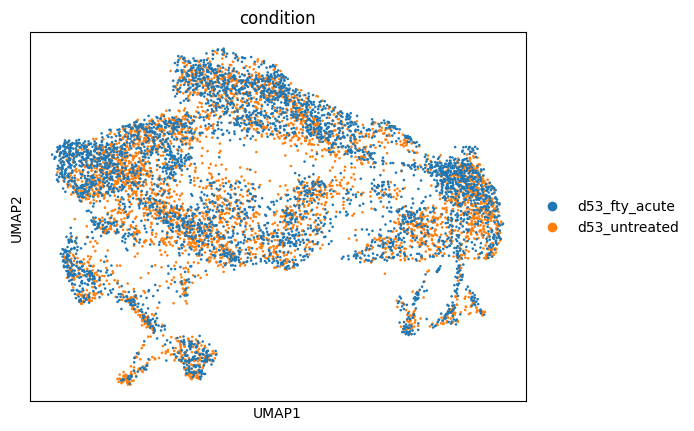

In [ ]:
kim_d53 = generate_umap(kim_d53)
sc.pl.umap(kim_d53, color='condition')

# Kim d77 samples - Data read-in

Read in Cellranger output files for day 77 untreated + chronic fentanyl samples and save as .h5ad.gz files

In [ ]:
sample1_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH003_Day77_Untreated"
adata1 = sc.read_10x_mtx(sample1_path, var_names="gene_symbols", cache=True)
adata1.obs["Sample"] = "kim_day77_untreated"
adata1.obs["condition"] = "d77_untreated"
adata1.obs.index = [f"d77_ut_{barcode}" for barcode in adata1.obs.index]
adata1.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ut.h5ad.gz", compression="gzip")

sample2_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH004_Day77_FTY_Chronic"
adata2 = sc.read_10x_mtx(sample2_path, var_names="gene_symbols", cache=True)
adata2.obs["Sample"] = "kim_d77_fty_chronic"
adata2.obs["condition"] = "d77_fty_chronic"
adata2.obs.index = [f"d77_fty_{barcode}" for barcode in adata2.obs.index]
adata2.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_fty.h5ad.gz", compression="gzip")

Concatenate samples into single `AnnData` object and save

In [ ]:
adata_combined = sc.concat([adata1, adata2], label="orig_sample", keys=["sample3", "sample4"])
adata_combined

AnnData object with n_obs × n_vars = 10033 × 33538
    obs: 'Sample', 'condition', 'orig_sample'

In [ ]:
adata_combined.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_combined.h5ad.gz", compression="gzip")

In [ ]:
del adata1, adata2, adata_combined
gc.collect()

135714

# Kim d77 samples - QC

Read in file

In [ ]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_combined.h5ad.gz")

Store raw counts and save file

In [ ]:
kim_d77.raw = kim_d77.copy()
kim_d77.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_combined.h5ad.gz", compression="gzip")

We will begin QC by calculating common QC metrics with `scanpy.pp.calculate_qc_metrics()`. We will also label mitochondrial, ribosomal, and hemoglobin genes.

In [ ]:
def qc_metrics(adata):
  # mitochondrial genes, "MT-" for human, "Mt-" for mouse
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
  # ribosomal genes
  adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
  # hemoglobin genes
  adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)

qc_metrics(kim_d77)

Inspect plots

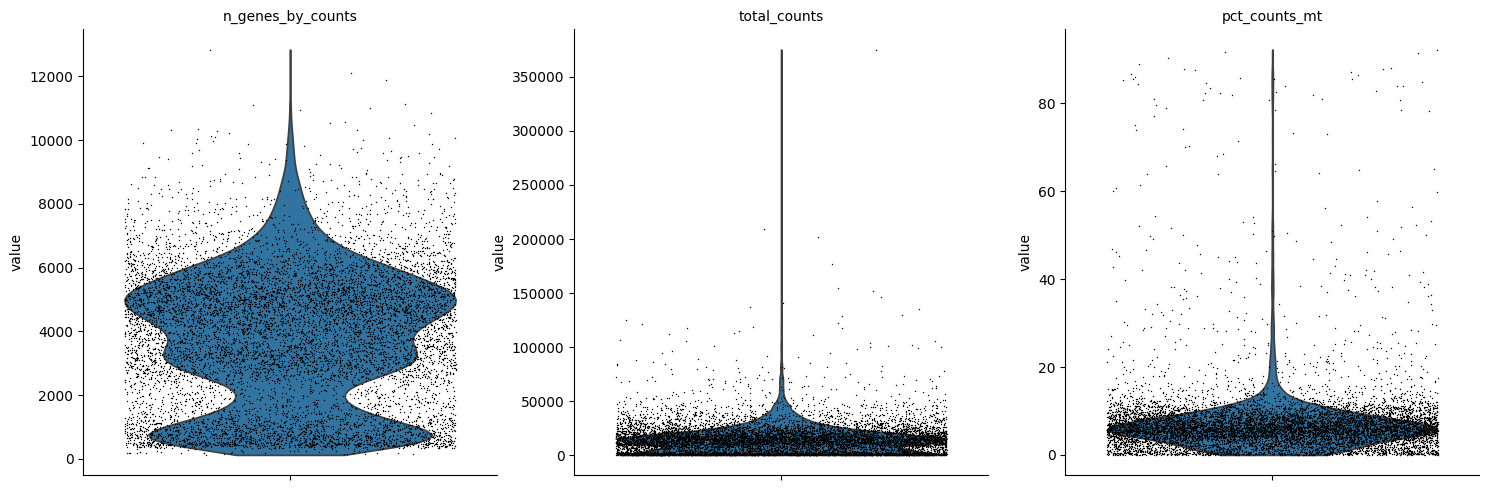

In [ ]:
sc.pl.violin(
    kim_d77,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

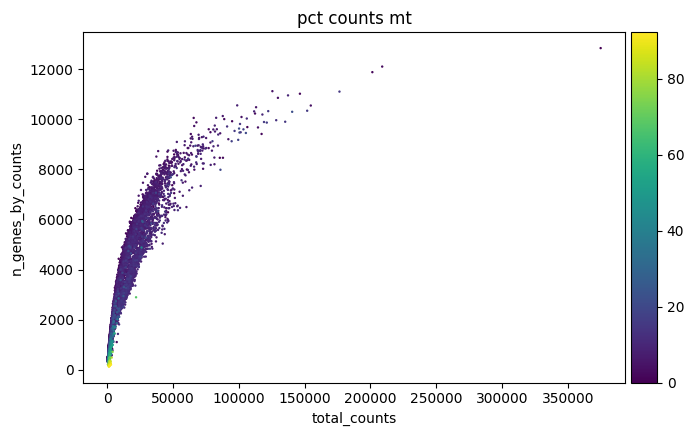

In [ ]:
sc.pl.scatter(kim_d77, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

To filter out low-quality cells, we will use automatic thresholding via MAD (median absolute deviations) following the [Single-Cell Best Practices](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) tutorial. We will mark cells as outliers if they differ by 3 MADs. For filtering out cells with a high percentage of mitochondrial genes, we will use 3 MADs. We will also manually set a threshold to filter out cells with >20% mitochondrial genes, consistent with brain organoid transcriptomic studies [Vertesy et al (2022)](https://www.embopress.org/doi/full/10.15252/embj.2022111118) and [Fleck et al (2023)](https://www.nature.com/articles/s41586-022-05279-8).

In [ ]:
def assign_outliers(adata):
  def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

  adata.obs["outlier"] = (
      is_outlier(adata, "log1p_total_counts", 3)
      | is_outlier(adata, "log1p_n_genes_by_counts", 3)
      | is_outlier(adata, "pct_counts_in_top_20_genes", 3)
      | is_outlier(adata, "pct_counts_mt", 3)
      | (adata.obs["pct_counts_mt"] > 20)
  )

assign_outliers(kim_d77)
kim_d77.obs.outlier.value_counts()

,count
outlier,
False,7481
True,2552


Apply thresholds

In [ ]:
kim_d77 = kim_d77[~kim_d77.obs.outlier].copy()

We will save the `AnnData` object with the cell barcodes and genes that passed QC as a `.h5ad.gz` file.

In [ ]:
kim_d77.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_qc.h5ad.gz", compression="gzip")

We will generate a preliminary UMAP on the QC-passed dataset before cell type annotation.

In [ ]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_qc.h5ad.gz")

In [ ]:
def generate_umap(adata):
  sc.pp.normalize_total(adata)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=2000)
  sc.tl.pca(adata)
  sc.pp.neighbors(adata)
  sc.tl.umap(adata)
  return adata

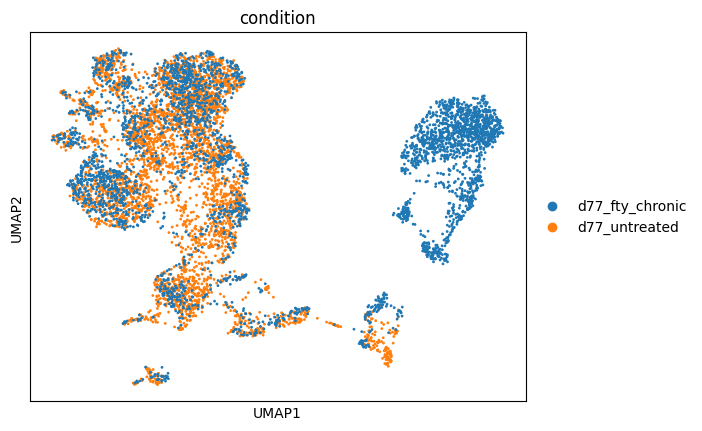

In [ ]:
kim_d77 = generate_umap(kim_d77)
sc.pl.umap(kim_d77, color='condition')

# Cell type annotation - preparing reference dataset

Kim et al performed cell type annotation by co-clustering with an annotated fetal midbrain scRNA-seq reference dataset from La Manno et al (2016). We will use the Python implementation of Symphony ([Kang et al 2021](https://)), symphonypy, to perform reference-based cell type annotation following the [tutorial](https://symphonypy.readthedocs.io/en/latest/Symphonypy_simple_tutorial.html) in the documentation.

## Read in La Manno et al dataset and create AnnData object

We want to create an AnnData object from the La Manno et al dataset. We will read in the La Manno et al dataset `.cef.txt` file. We will omit the first few header rows containing sample metadata from the `DataFrame` and read those in separately.

In [ ]:
la_manno_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE76381_EmbryoMoleculeCounts.cef.txt",
                            sep="\t", header=3, index_col=0)

In [ ]:
la_manno_df.head()

,Timepoint,week_7,week_7.1,week_7.2,week_7.3,week_7.4,week_7.5,week_7.6,week_7.7,week_7.8,week_7.9,week_7.10,week_7.11,week_7.12,week_7.13,week_7.14,week_7.15,week_7.16,week_7.17,week_7.18,week_7.19,week_7.20,week_7.21,week_7.22,week_7.23,week_7.24,week_7.25,week_7.26,week_7.27,week_7.28,week_7.29,week_7.30,week_7.31,week_7.32,week_7.33,week_7.34,week_7.35,week_7.36,week_7.37,week_7.38,week_7.39,week_7.40,week_7.41,week_7.42,week_7.43,week_7.44,week_7.45,week_7.46,week_7.47,week_7.48,...,week_8.281,week_8.282,week_8.283,week_8.284,week_8.285,week_8.286,week_8.287,week_8.288,week_8.289,week_8.290,week_8.291,week_8.292,week_8.293,week_8.294,week_8.295,week_8.296,week_8.297,week_8.298,week_8.299,week_8.300,week_8.301,week_8.302,week_8.303,week_8.304,week_8.305,week_8.306,week_8.307,week_8.308,week_8.309,week_8.310,week_8.311,week_8.312,week_8.313,week_8.314,week_8.315,week_8.316,week_8.317,week_8.318,week_8.319,week_8.320,week_8.321,week_8.322,week_8.323,week_8.324,week_8.325,week_8.326,week_8.327,week_8.328,week_8.329,week_8.330
Gene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DDX11L1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WASH7P_p1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01002_loc4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LOC100133331_loc1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is a gene-by-cell matrix, so we need to slice out the raw counts and transpose them so we can save them in the `.X` of the AnnData object.

In [ ]:
counts_start_row, counts_start_col = 1, 1
counts = la_manno_df.iloc[counts_start_row:, counts_start_col:].values.astype(np.float32)
counts[:5, :5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
counts = np.transpose(counts)
counts[:5, :5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

Get gene names to create `.var` of AnnData object

In [ ]:
genes = la_manno_df.index.tolist()[1:]
print(f"genes (length {len(genes)}): {genes[:5]}...")

genes (length 19531): ['DDX11L1', 'WASH7P_p1', 'LINC01002_loc4', 'LOC100133331_loc1', 'LOC100132287_loc2']...


Extract metadata from La Manno txt file to create `.obs` of AnnData object

In [ ]:
with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE76381_EmbryoMoleculeCounts.cef.txt") as f:
  txt = f.readlines()
  header = list()
  for i in range(4):
    header.append(txt[i].strip().split("\t"))
for i in range(4):
  print(f"header row {header[i][0]}, length {len(header[i])}, first few entries {header[i][:7]}")
cell_ids = header[1][1:]
print(f"cell_ids (length {len(cell_ids)}): {cell_ids[:5]} ...")
cell_types = header[2][1:]
print(f"cell_types (length {len(cell_types)}): {cell_types[:5]} ...")
time_points = header[3][1:]
print(f"timepoints (length {len(time_points)}): {time_points[:5]} ...")

header row CEF, length 7, first few entries ['CEF', '0', '1', '3', '19531', '1977', '0']
header row Cell_ID, length 1978, first few entries ['Cell_ID', '1772067_089_A01', '1772067_089_A02', '1772067_089_A03', '1772067_089_A04', '1772067_089_A05', '1772067_089_A06']
header row Cell_type, length 1978, first few entries ['Cell_type', 'hMgl', 'hRgl2a', 'Unk', 'hNProg', 'hProgBP', 'hProgM']
header row Timepoint, length 1978, first few entries ['Timepoint', 'week_7', 'week_7', 'week_7', 'week_7', 'week_7', 'week_7']
cell_ids (length 1977): ['1772067_089_A01', '1772067_089_A02', '1772067_089_A03', '1772067_089_A04', '1772067_089_A05'] ...
cell_types (length 1977): ['hMgl', 'hRgl2a', 'Unk', 'hNProg', 'hProgBP'] ...
timepoints (length 1977): ['week_7', 'week_7', 'week_7', 'week_7', 'week_7'] ...


Create `AnnData` object for La Manno et al dataset:

In [ ]:
lamanno_adata = sc.AnnData(X=counts, var=pd.DataFrame(index=genes), obs=pd.DataFrame(index=cell_ids))

Add cell types and timepoints as metadata to `.obs`:

In [ ]:
print(len(cell_types), len(time_points), len(lamanno_adata.obs))

1977 1977 1977


In [ ]:
lamanno_adata.obs['cell_type'] = cell_types
lamanno_adata.obs['time_point'] = time_points

In [ ]:
lamanno_adata

AnnData object with n_obs × n_vars = 1977 × 19531
    obs: 'cell_type', 'time_point'

Store raw counts

In [ ]:
lamanno_adata.raw = lamanno_adata.copy()

Save file:

In [ ]:
lamanno_adata.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/lamanno_adata.h5ad.gz", compression="gzip")

## Preprocess La Manno dataset according to Symphony tutorial

QC was performed on the La Manno dataset before it was uploaded to GEO. We can start preprocessing immediately.

In [ ]:
lamanno_adata = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/lamanno_adata.h5ad.gz")
lamanno_adata

AnnData object with n_obs × n_vars = 1977 × 19531
    obs: 'cell_type', 'time_point'

In [ ]:
# Filter out "Unk" cells
lamanno_adata = lamanno_adata[lamanno_adata.obs['cell_type'] != 'Unk', :].copy()
print(lamanno_adata.obs["cell_type"].unique().tolist())

['hMgl', 'hRgl2a', 'hNProg', 'hProgBP', 'hProgM', 'hOMTN', 'hDA0', 'hNbM', 'hProgFPL', 'hEndo', 'hProgFPM', 'hRgl2b', 'hNbML5', 'hRgl3', 'hRN', 'hPeric', 'hDA1', 'hRgl1', 'hGaba', 'hDA2', 'hSert', 'hNbGaba', 'hNbML1', 'hRgl2c', 'hOPC']


In [ ]:
# Update cell types in La Manno dataset based on Kim et al cell type groupings
cell_type_mapping = {'hEndo': 'Endo', 'hPeric': 'Peric', 'hMgl': 'Mgl', 'hOPC': 'OPC',
                     'hRgl2c': 'Rgl', 'hRgl2b': 'Rgl', 'hRgl2a': 'Rgl', 'hRgl3': 'Rgl', 'hRgl1': 'Rgl',
                     'hProgM': 'Prog', 'hProgBP': 'Prog', 'hProgFPL': 'Prog', 'hProgFPM': 'Prog', 'hNProg': 'NProg',
                     'hNbM': 'Nb', 'hNbML1': 'Nb', 'hRN': 'RN', 'hNbML5': 'Nb', 'hDA0': 'DA', 'hDA1': 'DA', 'hDA2': 'DA',
                     'hNbGaba': 'Nb', 'hGaba': 'Gaba', 'hSert': 'Sert', 'hOMTN': 'OMTN'}
# Apply the mapping to the cell_type column in adata_ref.obs
lamanno_adata.obs['cell_type'] = lamanno_adata.obs['cell_type'].map(cell_type_mapping).fillna(lamanno_adata.obs['cell_type'])
print(list(lamanno_adata.obs["cell_type"].unique()))

['Mgl', 'Rgl', 'NProg', 'Prog', 'OMTN', 'DA', 'Nb', 'Endo', 'RN', 'Peric', 'Gaba', 'Sert', 'OPC']


In [ ]:
# Preprocessing and clustering based on Symphonypy tutorial
def symphony_pp_cluster(adata):
  sc.pp.normalize_total(adata, target_sum=1e5)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=3000)
  adata = adata[:, adata.var.highly_variable].copy()
  sc.pp.scale(adata, max_value=10)
  sc.pp.pca(adata, n_comps=30, zero_center=False)
  sc.pp.neighbors(adata)
  sc.tl.umap(adata)
  sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
  return adata

In [ ]:
lamanno_adata = symphony_pp_cluster(lamanno_adata)

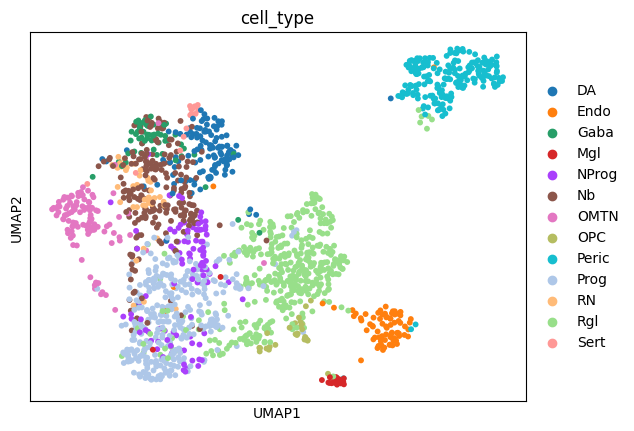

In [ ]:
sc.pl.umap(lamanno_adata, color="cell_type")

Save La Manno preprocessed reference dataset

In [ ]:
lamanno_adata.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/lamanno_adata_pp_ref.h5ad.gz", compression="gzip")

# Kim d53 samples - annotate cell types

Read in QC-passed data

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz")

Save raw counts

In [ ]:
kim_d53.raw = kim_d53.copy()
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz", compression="gzip")

Preprocess Kim d53 dataset the same way as La Manno dataset

In [ ]:
# Preprocessing and clustering based on Symphonypy tutorial
def symphony_pp(adata):
  sc.pp.normalize_total(adata, target_sum=1e5)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=3000)
  adata = adata[:, adata.var.highly_variable].copy()
  sc.pp.scale(adata, max_value=10)
  sc.pp.pca(adata, n_comps=30, zero_center=False)
  return adata

In [ ]:
kim_d53 = symphony_pp(kim_d53)

Perform annotation on Kim d53 dataset with Symphony

In [ ]:
def run_symphony(query, ref):
  # Running Symphony
  sp.tl.map_embedding(
      adata_query=query,
      adata_ref=ref
  )
  # Mapping UMAP coordinates
  sp.tl.ingest(
      adata_query=query,
      adata_ref=ref,
      use_rep="X_pca",
  )
  # Labels prediction
  sp.tl.transfer_labels_kNN(
      adata_query=query,
      adata_ref=ref,
      ref_labels=["cell_type"],
      ref_basis="X_pca",
      query_basis="X_pca",
  )

In [ ]:
run_symphony(kim_d53, lamanno_adata)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/symphonypy/tools.py:250: FutureWarning: The specified parameters ('inplace',) are no longer positional. Please specify them like `inplace=True`
  return ing.to_adata(inplace)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Visualize UMAPs of Kim d53 and La Manno data colored by cell type

<Axes: title={'center': 'La Manno reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

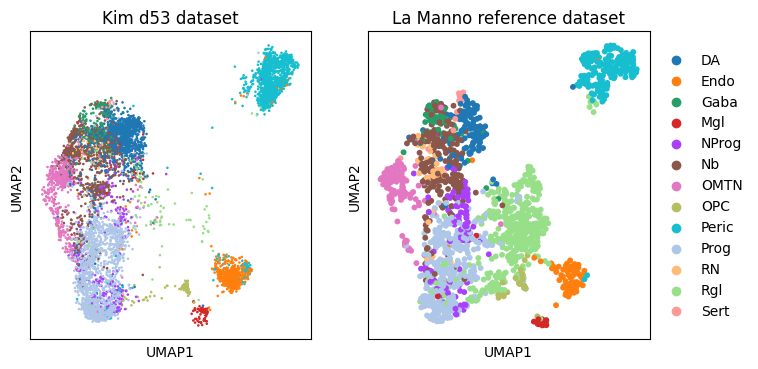

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    kim_d53,
    color="cell_type",
    title="Kim d53 dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    lamanno_adata,
    color="cell_type",
    title="La Manno reference dataset",
    ax=axes[1],
    show=False,
)

Visualize UMAP of Kim d53 data colored by treatment condition

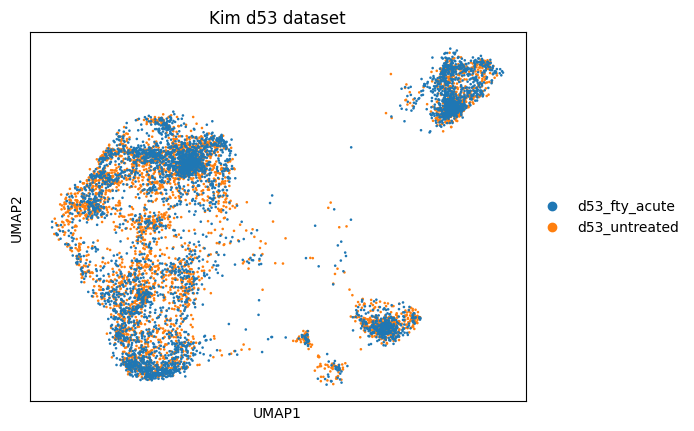

In [ ]:
sc.pl.umap(
    kim_d53,
    color="condition",
    title="Kim d53 dataset"
)

Save annotated dataset

In [ ]:
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ann.h5ad.gz", compression="gzip")

# Kim d77 samples - annotate cell types

Read in QC-passed data

In [ ]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_qc.h5ad.gz")

Save raw counts

In [ ]:
kim_d77.raw = kim_d77.copy()
kim_d77.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_qc.h5ad.gz", compression="gzip")

Preprocess Kim d77 dataset the same way as La Manno dataset

In [ ]:
# Preprocessing and clustering based on Symphonypy tutorial
def symphony_pp(adata):
  sc.pp.normalize_total(adata, target_sum=1e5)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=3000)
  adata = adata[:, adata.var.highly_variable].copy()
  sc.pp.scale(adata, max_value=10)
  sc.pp.pca(adata, n_comps=30, zero_center=False)
  return adata

In [ ]:
kim_d77 = symphony_pp(kim_d77)

Perform annotation on Kim d77 dataset with Symphony

In [ ]:
def run_symphony(query, ref):
  # Running Symphony
  sp.tl.map_embedding(
      adata_query=query,
      adata_ref=ref
  )
  # Mapping UMAP coordinates
  sp.tl.ingest(
      adata_query=query,
      adata_ref=ref,
      use_rep="X_pca",
  )
  # Labels prediction
  sp.tl.transfer_labels_kNN(
      adata_query=query,
      adata_ref=ref,
      ref_labels=["cell_type"],
      ref_basis="X_pca",
      query_basis="X_pca",
  )

In [ ]:
run_symphony(kim_d77, lamanno_adata)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/symphonypy/tools.py:250: FutureWarning: The specified parameters ('inplace',) are no longer positional. Please specify them like `inplace=True`
  return ing.to_adata(inplace)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Visualize UMAPs for cell type annotation

<Axes: title={'center': 'La Manno reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

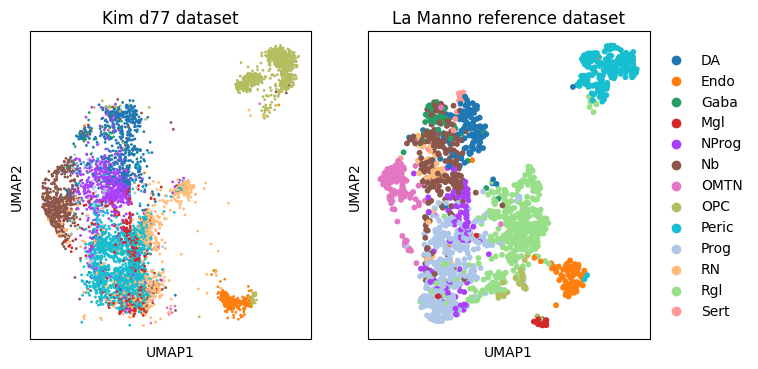

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    kim_d77,
    color="cell_type",
    title="Kim d77 dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    lamanno_adata,
    color="cell_type",
    title="La Manno reference dataset",
    ax=axes[1],
    show=False,
)

Visualize Kim d77 UMAP colored by treatment condition

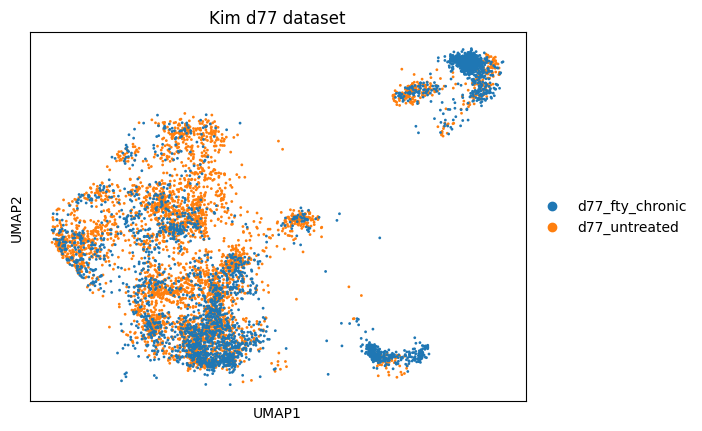

In [ ]:
sc.pl.umap(
    kim_d77,
    color="condition",
    title="Kim d77 dataset"
)

Save annotated dataset

In [ ]:
kim_d77.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ann.h5ad.gz", compression="gzip")

# Kim both datasets - visualize UMAPs after cell type annotation

In [4]:
lamanno_adata = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/lamanno_adata_pp_ref.h5ad.gz")
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ann.h5ad.gz")
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ann.h5ad.gz")

Visualize cell type annotation with reference dataset

In [12]:
all_cell_types = list(lamanno_adata.obs["cell_type"].unique())
print(all_cell_types)
cmap = plt.get_cmap("tab20")
cell_palette = {all_cell_types[i]: cmap(i) for i in range(len(all_cell_types))}
#cell_palette = {cell_type: cmap(i / len(all_cell_types)) for i, cell_type in enumerate(all_cell_types)}

['Mgl', 'Rgl', 'NProg', 'Prog', 'OMTN', 'DA', 'Nb', 'Endo', 'RN', 'Peric', 'Gaba', 'Sert', 'OPC']


In [ ]:
# Color palette
all_cell_types = ["DA", "Endo", "Gaba", "Mgl", "NProg", "Nb", "OMTN", "OPC", "Peric", "Prog", "RN", "Rgl", "Sert"]
base_colors = plt.get_cmap("tab10").colors
# Define additional colors
extra_colors = sns.color_palette("husl", 3)  # 'husl' generates distinct colors
# Combine them into one palette
custom_palette = list(base_colors) + list(extra_colors)
cell_palette = {cell: color for cell, color in zip(all_cell_types, custom_palette)}

<Axes: title={'center': 'La Manno reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

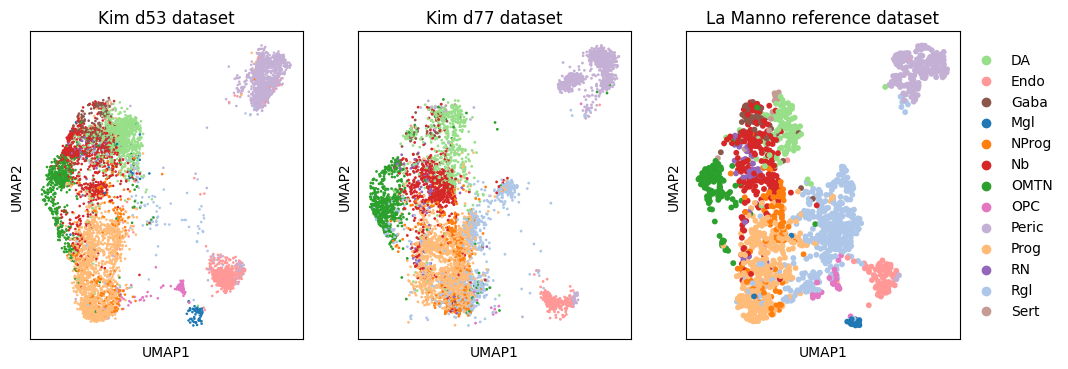

In [15]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)

sc.pl.umap(
    kim_d53,
    color="cell_type",
    palette=cell_palette,
    title="Kim d53 dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    kim_d77,
    color="cell_type",
    palette=cell_palette,
    title="Kim d77 dataset",
    ax=axes[1],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    lamanno_adata,
    color="cell_type",
    palette=cell_palette,
    title="La Manno reference dataset",
    ax=axes[2],
    show=False,
)

Visualize treatment conditions and time points

<Axes: title={'center': 'Kim d77 dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

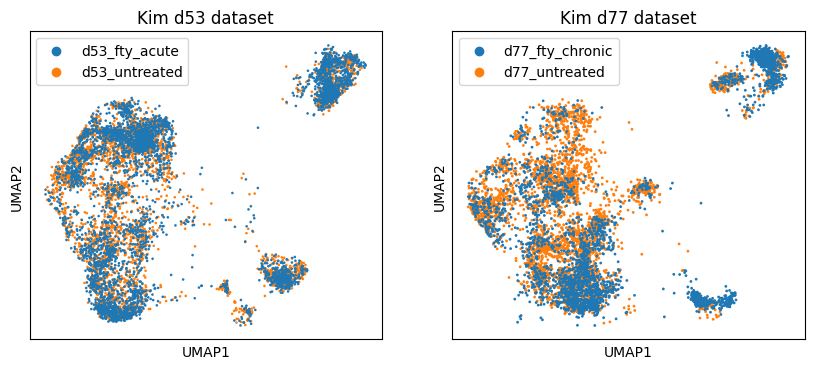

In [ ]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)

sc.pl.umap(
    kim_d53,
    color="condition",
    title="Kim d53 dataset",
    ax=axes[0],
    show=False,
    legend_loc="best"
)

sc.pl.umap(
    kim_d77,
    color="condition",
    title="Kim d77 dataset",
    ax=axes[1],
    show=False,
    legend_loc="best"
)

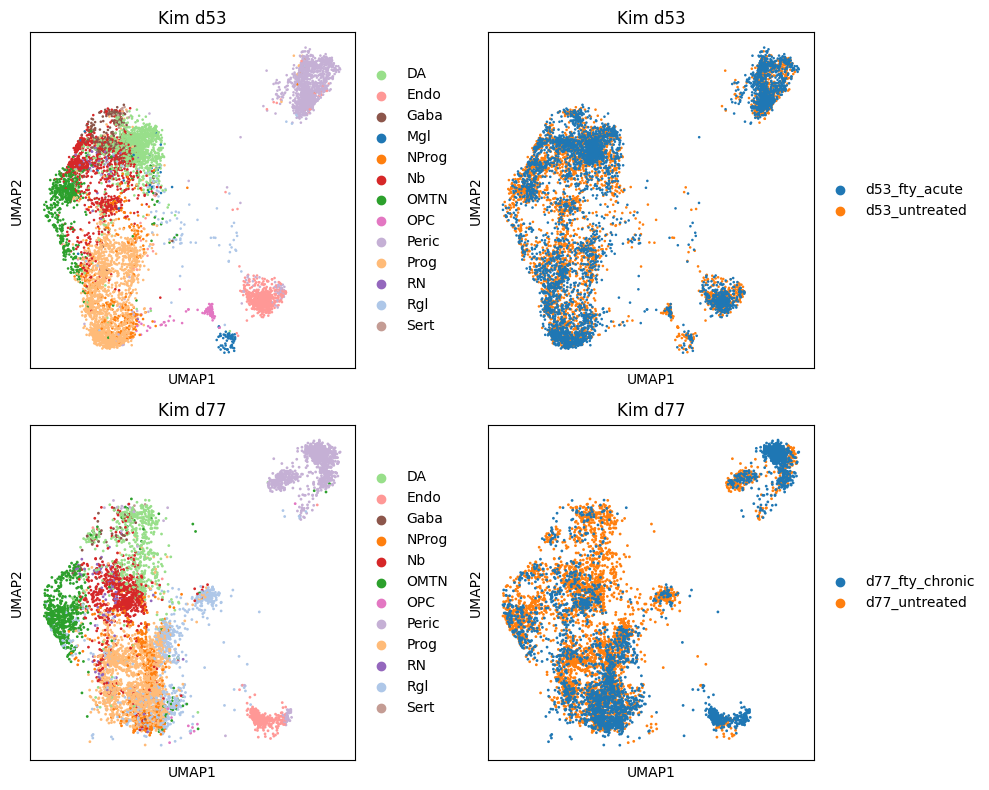

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sc.pl.umap(
    kim_d53,
    color="cell_type",
    palette=cell_palette,
    title="Kim d53",
    ax=axes[0][0],
    show=False
)

sc.pl.umap(
    kim_d53,
    color="condition",
    title="Kim d53",
    ax=axes[0][1],
    show=False
)

sc.pl.umap(
    kim_d77,
    color="cell_type",
    palette=cell_palette,
    title="Kim d77",
    ax=axes[1][0],
    show=False
)

sc.pl.umap(
    kim_d77,
    color="condition",
    title="Kim d77",
    ax=axes[1][1],
    show=False
)
fig.tight_layout()

# Kim d53 - analysis on cell-type-annotated data

Read in data

In [292]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ann.h5ad.gz")

## Generate Kim d53 annotated single-rep pseudobulk dataset

First, we will generate a pseudobulk profile for each cell type with no pseudoreplicates. Because `decoupler.get_pseudobulk` uses raw counts, we will reassign the raw counts to X:

In [293]:
kim_d53.X = kim_d53.raw[:, kim_d53.var_names].X.copy()

View cell types:

In [ ]:
cell_type_counts = kim_d53.obs['cell_type'].value_counts()
print(cell_type_counts)

cell_type
Prog     1875
Peric    1839
DA       1548
Nb       1051
Endo      775
OMTN      547
Gaba      309
NProg     277
OPC       123
Rgl       115
Mgl       101
RN         55
Sert       16
Name: count, dtype: int64


Use `decoupler` to generate pseudobulk profile (without pseudoreplicates) for the 2 samples and 13 cell types in `kim_d53`

In [294]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    kim_d53,
    sample_col='condition',
    groups_col='cell_type',
    use_raw=True,
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 25 × 2500
    obs: 'condition', 'cell_type', 'Sample', 'orig_sample', 'outlier', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    layers: 'psbulk_props'

PCA

In [295]:
def pseudobulk_pca(pdata):
  # Store raw counts in layers
  pdata.layers['counts'] = pdata.X.copy()

  # Normalize, scale and compute pca
  sc.pp.normalize_total(pdata, target_sum=1e4)
  sc.pp.log1p(pdata)
  sc.pp.scale(pdata, max_value=10)
  sc.tl.pca(pdata)

  # Return raw counts to X
  dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [296]:
pseudobulk_pca(pdata)

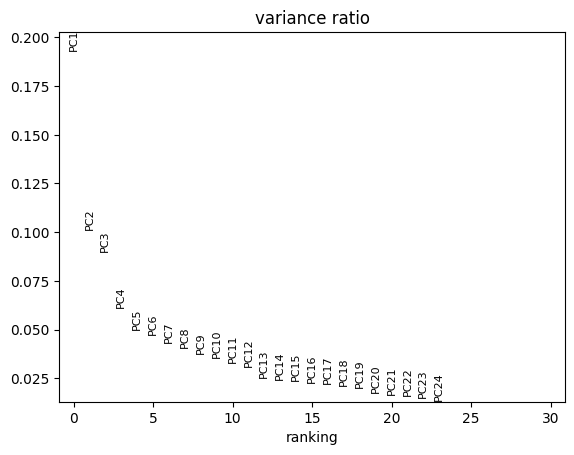

In [ ]:
sc.pl.pca_variance_ratio(pdata)

In order to have a better overview of the association of PCs with sample metadata, let’s perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples


In [297]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['condition', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

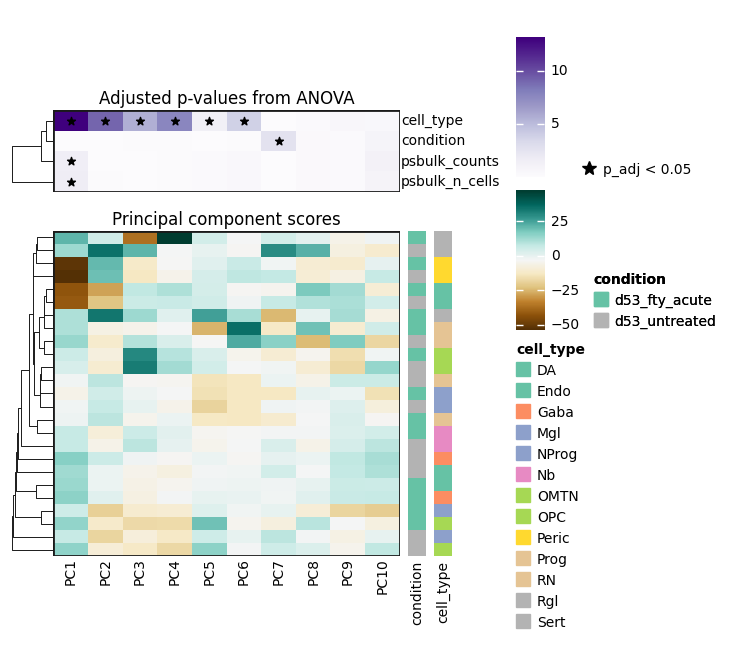

In [ ]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'cell_type'], # which sample annotations to plot
    titles=['Principal component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

## Kim d53 pseudobulk - differential expression analysis with `PyDESeq2`

In [298]:
kim_d53_dds = DeseqDataSet(
    adata=pdata,
    design='~condition'
)
kim_d53_dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.29 seconds.

Fitting dispersion trend curve...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 3.50 seconds.

Fitting LFCs...
... done in 2.65 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 62 outlier genes.

Fitting dispersions...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.13 seconds.

Fitting LFCs...
... done in 0.12 seconds.



In [299]:
kim_d53_ds = DeseqStats(kim_d53_dds, contrast=["condition", "d53_fty_acute", "d53_untreated"])
kim_d53_ds.summary()

Running Wald tests...
... done in 0.85 seconds.



Log2 fold change & Wald test p-value: condition d53_fty_acute vs d53_untreated
             baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG        73.783687        0.179835  0.220968  0.813851  0.415730  0.9997
A2M          0.123790        0.049306  2.481005  0.019873  0.984144  0.9997
A2ML1-AS2    0.489812       -0.246040  0.804313 -0.305901  0.759680  0.9997
AAMDC       60.461114       -0.040455  0.124778 -0.324213  0.745777  0.9997
AANAT      137.434448        0.408666  0.173447  2.356148  0.018466  0.9997
...               ...             ...       ...       ...       ...     ...
ZNF679       2.023071        0.265253  0.493255  0.537760  0.590743  0.9997
ZNF716       0.281445       -0.093150  2.446817 -0.038070  0.969632  0.9997
ZNF766       0.022608        0.289497  3.223929  0.089796  0.928449  0.9997
ZNF860     189.217938        0.002787  0.167252  0.016665  0.986704  0.9997
ZWINT        1.355299        0.552025  0.667193  0.827383  0.408020  0.9997

[2500 ro

In [308]:
kim_d53_ds.lfc_shrink(coeff="condition[T.d53_untreated]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.d53_untreated]
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
CARD10       0.609408       -0.000633  0.062285  1.680884  0.092785  0.999700
AL445989.1   0.123638       -0.001134  0.048796  0.831608  0.405631  0.999700
INO80B-WBP1  0.380317       -0.001744  0.052879  1.038739  0.298926  0.999700
AC084880.4   0.330871       -0.002169  0.053770  1.178001  0.238796  0.999700
DPEP1        1.328080       -0.001377  0.060289  1.760488  0.078325  0.999700
...               ...             ...       ...       ...       ...       ...
MSX2         1.522147        0.000621  0.064146 -1.840068  0.065758  0.999700
LINC01833    0.870918        0.000332  0.080495 -0.591322  0.554305  0.999700
CALD1        3.308026        0.007195  0.086848 -2.318031  0.020448  0.999700
NFAM1        0.404400        0.000830  0.158845 -0.697931  0.485220  0.999700
BX072579.1   2.053135        1.317864  0.836922 -2.624783  0.008670  0

... done in 20.17 seconds.



In [365]:
kim_d53_results = kim_d53_ds.results_df
kim_d53_results.sort_values('log2FoldChange', ascending = False, inplace=True)
kim_d53_results
kim_d53_degs_df = kim_d53_results[kim_d53_results["padj"] <= 0.05]
kim_d53_degs_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
IER2,153.504279,-0.442801,0.081965,5.858706,4.664890e-09,0.000009
BMP7-AS1,31.123163,-0.694168,0.145691,5.300011,1.157959e-07,0.000096
RPL6,45.295739,-0.785600,0.148047,5.781822,7.389593e-09,0.000009


Generate volcano plot

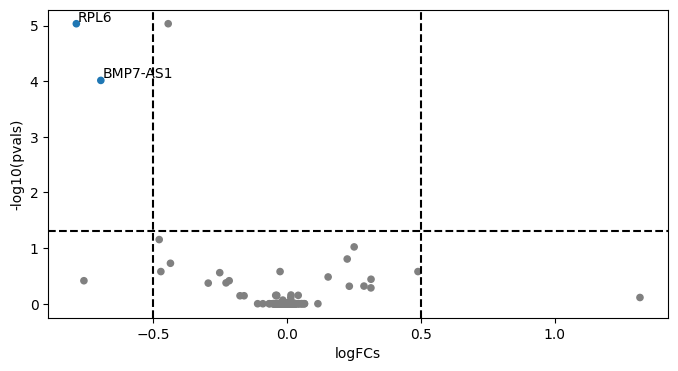

In [366]:
dc.plot_volcano_df(
    kim_d53_results,
    x='log2FoldChange',
    y='padj',
    top=3,
    figsize=(8, 4)
)

Only 3 DEGs were detected when performing DEA with `pydeseq2` on the Kim dataset with one pseudobulk profile per cell type. We will try `scanpy.rank_genes_groups` next.

## Kim d53 annotated single-cell dataset - DEA with `scanpy.rank_genes_groups`

In [279]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ann.h5ad.gz")
kim_d53

AnnData object with n_obs × n_vars = 8631 × 3000
    obs: 'Sample', 'condition', 'orig_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_symphony_R', 'X_pca_reference', 'X_umap'
    varm: 'PCs'

Preprocessing

In [280]:
kim_d53.X = kim_d53.raw[:, kim_d53.var_names].X.copy()
sc.pp.normalize_total(kim_d53)
sc.pp.log1p(kim_d53)

DEA with scanpy

In [281]:
# Perform DEA
sc.tl.rank_genes_groups(kim_d53, "condition", method="wilcoxon", use_raw=False)
# Get DEGs
kim_d53_degs = sc.get.rank_genes_groups_df(kim_d53, group="d53_fty_acute")

In [284]:
# Filter DEGs by p-value and log fold change
kim_d53_degs = kim_d53_degs[(kim_d53_degs['pvals_adj'] < 0.05) & (abs(kim_d53_degs['logfoldchanges']) > 0.5)].copy()
kim_d53_degs

,names,scores,logfoldchanges,pvals,pvals_adj
9,NPAS4,8.582278,0.893333,9.301234e-18,1.550206e-15
13,BDNF,7.155029,0.661639,8.365504e-13,7.170432e-11
19,HSPA6,6.462338,0.785494,1.030976e-10,5.835711e-09
25,SNTG1,5.851209,0.785263,4.880133e-09,2.033389e-07
27,MT1X,5.767166,0.507624,8.061590e-09,3.140879e-07
30,CCNB1,5.530670,0.777988,3.190110e-08,1.100038e-06
35,PHLDA1,4.904589,0.580163,9.362299e-07,2.624944e-05
45,KIF20B,4.242362,0.649489,2.211799e-05,4.832772e-04
52,SMC4,4.080689,0.666400,4.490231e-05,8.775226e-04
63,WEE1,3.631794,0.521812,2.814573e-04,4.420795e-03


# Kim d77 - analysis on cell-type-annotated Kim pseudobulk data

## Generate Kim d77 annotated single-rep pseudobulk dataset

Read in data

In [235]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ann.h5ad.gz")

First, we will generate a pseudobulk profile for each cell type with no pseudoreplicates. Because `decoupler.get_pseudobulk` uses raw counts, we will reassign the raw counts to X:

In [236]:
kim_d77.X = kim_d77.raw[:, kim_d77.var_names].X.copy()

View cell types:

In [86]:
cell_type_counts = kim_d77.obs['cell_type'].value_counts()
print(cell_type_counts)

cell_type
Prog     1856
Peric    1658
Rgl       883
Nb        800
OMTN      632
DA        613
NProg     489
Endo      366
RN        126
Gaba       43
OPC        11
Sert        4
Name: count, dtype: int64


Use `decoupler` to generate pseudobulk profile (without pseudoreplicates) for the 2 samples and 12 cell types in `kim_d77`

In [238]:
# Get filtered pseudo-bulk profile
pdata_d77 = dc.get_pseudobulk(
    kim_d77,
    sample_col='condition',
    groups_col='cell_type',
    use_raw=True,
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata_d77

AnnData object with n_obs × n_vars = 20 × 2427
    obs: 'condition', 'cell_type', 'Sample', 'orig_sample', 'outlier', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    layers: 'psbulk_props'

Only 10 cell types fulfiilled the minimum requirement of 10 cells and 1000 counts across all cells of that type. View these cell types:

In [92]:
print(list(pdata.obs["cell_type"].unique()))

['DA', 'Endo', 'Gaba', 'NProg', 'Nb', 'OMTN', 'Peric', 'Prog', 'RN', 'Rgl']


PCA

In [88]:
def pseudobulk_pca(pdata):
  # Store raw counts in layers
  pdata.layers['counts'] = pdata.X.copy()

  # Normalize, scale and compute pca
  sc.pp.normalize_total(pdata, target_sum=1e4)
  sc.pp.log1p(pdata)
  sc.pp.scale(pdata, max_value=10)
  sc.tl.pca(pdata)

  # Return raw counts to X
  dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [239]:
pseudobulk_pca(pdata_d77)

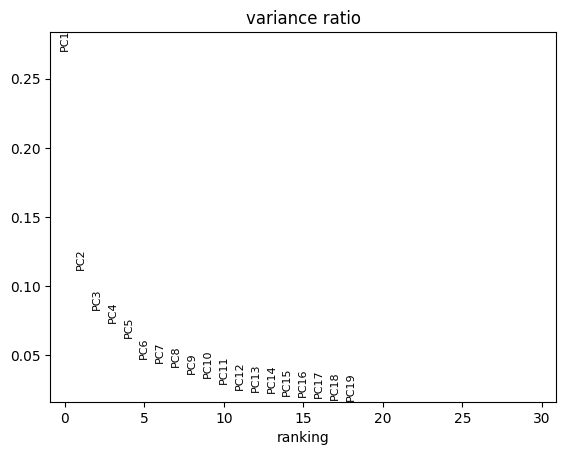

In [90]:
sc.pl.pca_variance_ratio(pdata_d77)

In order to have a better overview of the association of PCs with sample metadata, let’s perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples


In [94]:
dc.get_metadata_associations(
    pdata_d77,
    obs_keys = ['condition', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

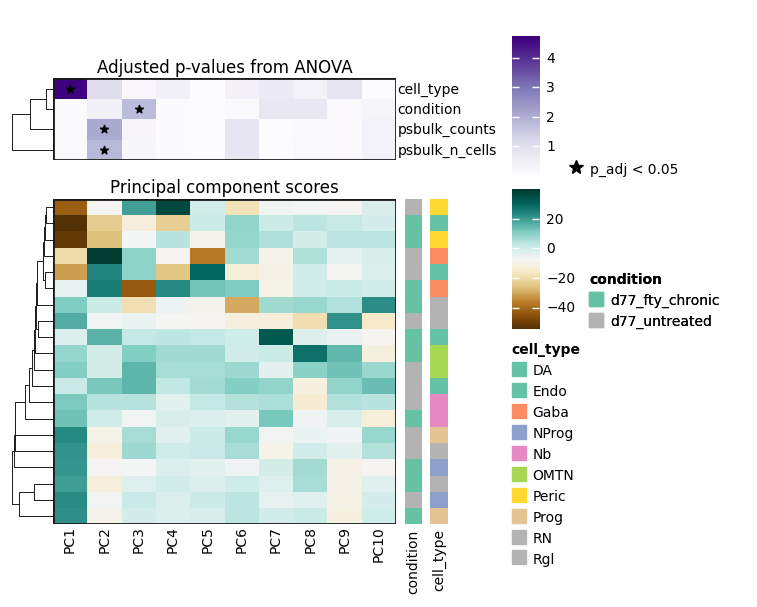

In [95]:
dc.plot_associations(
    pdata_d77,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'cell_type'], # which sample annotations to plot
    titles=['Principal component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

## Kim d77 pseudobulk - DEA with `PyDESeq2`

Run DEA

In [240]:
kim_d77_dds = DeseqDataSet(
    adata=pdata_d77,
    design='~condition'
)
kim_d77_dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 7.69 seconds.

Fitting dispersion trend curve...
/usr/local/lib/python3.11/dist-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 7.82 seconds.

Fitting LFCs...
... done in 8.35 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 113 outlier genes.

Fitting dispersions...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 0.60 seconds.

Fitting LFCs...
... done in 0.30 seconds.



In [241]:
kim_d77_ds = DeseqStats(kim_d77_dds, contrast=["condition", "d77_fty_chronic", "d77_untreated"])
kim_d77_ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition d77_fty_chronic vs d77_untreated
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2M       0.219192        0.097779  1.630553  0.059967  0.952182       NaN
A2ML1     0.028423       -0.047468  2.806197 -0.016915  0.986504       NaN
AANAT     1.895792       -0.448928  0.586894 -0.764922  0.444318  0.947868
ABCA1     1.294396        1.705647  1.197615  1.424202  0.154388  0.861494
ABCA13    0.145811        1.768615  3.031200  0.583470  0.559577       NaN
...            ...             ...       ...       ...       ...       ...
ZNF750    1.651168       -0.469896  0.752105 -0.624774  0.532119  0.948635
ZPLD1   101.365388       -0.362345  0.164515 -2.202510  0.027629  0.462515
ZSCAN4    0.018629        0.755861  3.308975  0.228427  0.819314       NaN
ZWINT     2.110168        0.346234  0.797675  0.434054  0.664249  0.968293
ZYG11A  389.536022        0.124642  0.165978  0.750955  0.452680  0.947868

[2427 rows x 6 col

... done in 1.45 seconds.



In [242]:
kim_d77_results = kim_d77_ds.results_df
kim_d77_results.sort_values('log2FoldChange', ascending = False, inplace=True)
kim_d77_degs_df = kim_d77_results[kim_d77_results["padj"] <= 0.05]
kim_d77_degs_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
HOXD8,14.125493,6.106491,1.598761,3.819514,1.337148e-04,0.015559
SPX,23.200972,4.824046,0.819962,5.883257,4.022699e-09,0.000007
AC098934.4,3.996398,4.671809,0.922073,5.066637,4.049055e-07,0.000136
ADCYAP1,6.061764,3.401651,0.733734,4.636083,3.550738e-06,0.000743
TYMS,12.276818,2.452196,0.687407,3.567313,3.606612e-04,0.033541
RPL22L1,14.656045,1.948172,0.550455,3.539205,4.013339e-04,0.035360
DHFR,93.626597,1.190443,0.232404,5.122296,3.018374e-07,0.000126
MC4R,10.932221,0.965330,0.256526,3.763082,1.678324e-04,0.017559
LINC01448,133.115487,0.841448,0.149370,5.633330,1.767630e-08,0.000015
WNT7B,164.376204,0.792421,0.201090,3.940620,8.127131e-05,0.012368


Perform LFC shrinkage

In [243]:
kim_d77_ds.lfc_shrink(coeff="condition[T.d77_untreated]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.d77_untreated]
             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
HOXD8       14.125493       -0.004815  0.079135  3.819514  1.337148e-04   
AL359182.1   2.583969       -0.000078  0.099582  1.742163  8.147997e-02   
SPX         23.200972       -0.030584  0.082271  5.883257  4.022699e-09   
AC098934.4   3.996398      -10.622514  0.995099  5.066637  4.049055e-07   
LINC01970    3.621083        0.004359  0.129183  3.068547  2.151021e-03   
...               ...             ...       ...       ...           ...   
AC079031.1   2.946329       -0.005146  0.081851 -1.797141  7.231328e-02   
PRELP        2.417766        0.003643  0.264008 -1.309846  1.902480e-01   
ACKR3        3.323280        0.000942  0.107548 -1.760143  7.838358e-02   
AC079336.5   3.876355        0.007921  0.152333 -2.422971  1.539414e-02   
AC073592.1  20.736487        2.195434  1.079918 -4.665683  3.075930e-06   

                padj  
HOXD

... done in 7.05 seconds.



In [305]:
kim_d77_results = kim_d77_ds.results_df
kim_d77_results.sort_values('log2FoldChange', ascending = False, inplace=True)
kim_d77_degs_df = kim_d77_results[kim_d77_results["padj"] <= 0.05]
kim_d77_degs_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AC073592.1,20.736487,2.195434,1.079918,-4.665683,3.075930e-06,0.000736
AC126175.1,45.001606,0.686662,0.217525,-3.849388,1.184134e-04,0.015559
AC009041.1,263.824458,0.605037,0.150483,-4.603133,4.161817e-06,0.000774
PTAFR,1016.473890,0.437176,0.130273,-4.008694,6.105544e-05,0.010221
HOXD8,14.125493,-0.004815,0.079135,3.819514,1.337148e-04,0.015559
SPX,23.200972,-0.030584,0.082271,5.883257,4.022699e-09,0.000007
TYMS,12.276818,-0.038099,0.091085,3.567313,3.606612e-04,0.033541
ADCYAP1,6.061764,-0.049995,0.103425,4.636083,3.550738e-06,0.000743
CFH,131.221762,-0.230098,0.078748,3.577519,3.468707e-04,0.033541
AL139041.1,559.369294,-0.266911,0.099202,3.432836,5.973035e-04,0.049994


In [245]:
kim_d77_degs_df.shape

(20, 6)

Generate volcano plot

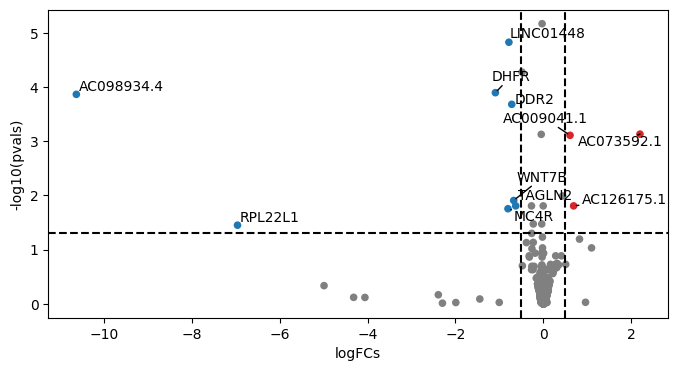

In [306]:
dc.plot_volcano_df(
    kim_d77_results,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)

## Generate Kim d77 2-pseudorep-per-cell-type pseudobulk dataset

First, we will generate a pseudobulk profile for each cell type with two pseudoreplicates per cell type. For each cell type and each condition, we will try to generate 2 pseudoreplicates with 50 randomly chosen cells each, but if that is not possible then we will divide the cells evenly into 2 pseudoreplicates.

In [322]:
def generate_pseudobulk_profiles(adata, n_cells=50, n_reps=2):
    pseudobulk_list = []

    # Ensure condition column exists
    if "condition" not in adata.obs.columns:
        raise ValueError("Metadata column 'condition' not found in adata.obs")

    for cell_type in adata.obs["cell_type"].unique():
        cell_type_data = adata[adata.obs["cell_type"] == cell_type]

        # Ensure cells from both conditions are represented
        for condition in cell_type_data.obs["condition"].unique():
            cond_data = cell_type_data[cell_type_data.obs["condition"] == condition]

            total_cells = cond_data.n_obs
            if total_cells < n_cells * n_reps:
                # Evenly divide the available cells
                indices = np.array_split(np.random.permutation(total_cells), n_reps)
            else:
                # Randomly sample n_cells for each replicate
                indices = [np.random.choice(total_cells, n_cells, replace=False) for _ in range(n_reps)]

            for i, idx in enumerate(indices):
                sampled_data = cond_data[idx]

                # Sum counts per gene across sampled cells
                pseudobulk_counts = np.asarray(sampled_data.layers["counts"].sum(axis=0)).reshape(1, -1)

                # Create a new AnnData object
                pseudo_adata = ad.AnnData(
                    X=pseudobulk_counts,
                    var=adata.var,
                    obs=pd.DataFrame({"cell_type": [cell_type],
                                      "condition": [condition],
                                      "sample_id": [f"{cell_type}_{condition}_rep{i+1}"]})
                )

                pseudobulk_list.append(pseudo_adata)

    # Concatenate all pseudobulk profiles
    pseudobulk_adata = ad.concat(pseudobulk_list, join="outer", merge="first")
    pseudobulk_adata.obs_names_make_unique()
    return pseudobulk_adata


In [ ]:
kim_d77.layers["counts"] = kim_d77.raw[:, kim_d77.var_names].X.copy()
pb2_d77 = generate_pseudobulk_profiles(kim_d77, n_cells=50, n_reps=2)
pb2_d77

In [340]:
pb2_d77

AnnData object with n_obs × n_vars = 48 × 3000
    obs: 'cell_type', 'condition', 'sample_id'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'design_matrix_buffer'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes'
    layers: 'normed_counts', '_mu_hat'

In [316]:
pb2_d77.obs['condition'].unique()

array(['d77_untreated', 'd77_fty_chronic'], dtype=object)

Run GSEA

In [341]:
gsea_d77_go2 = gp.gsea(
    data=pb2_d77.to_df().T, # row -> genes, column-> samples
    gene_sets="GO_Biological_Process_2023",
    cls=pb2_d77.obs.condition,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

/usr/local/lib/python3.11/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [342]:
gsea_d77_go_res2 = gsea_d77_go2.res2d.head()
gsea_d77_go_res2.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Actin Filament Organization (GO:0007015),-0.55222,-1.63602,0.026465,1.0,0.511,5/16,7.65%,RFLNA;SCIN;TTN;CAPG;ACTC1
1,gsea,Negative Regulation Of Developmental Process (...,-0.526743,-1.610234,0.018797,1.0,0.557,9/28,9.04%,SFRP5;GREM1;SOX9;FGFR3;BNIP3;SFRP1;SLC18A1;FOX...
2,gsea,Skeletal System Development (GO:0001501),-0.609955,-1.541933,0.065764,1.0,0.649,21/55,3.61%,MATN3;UCMA;SNORC;CNMD;RFLNA;EPYC;COL11A2;NOG;C...
3,gsea,Negative Regulation Of Protein Metabolic Proce...,0.50166,1.480956,0.075435,1.0,0.725,10/19,28.43%,PITX3;PLAT;CRYAB;GZMB;FLNA;EDNRB;BTG2;SERPINE2...
4,gsea,Adenylate Cyclase-Activating G Protein-Coupled...,0.533807,1.466453,0.074656,1.0,0.737,9/21,16.29%,ADM2;PTGER4;ADRA2A;CALCA;CXCL10;MC4R;PTHLH;ADG...


In [343]:
gsea_d77_go_res2 = gsea_d77_go_res2[gsea_d77_go_res2["FDR q-val"] < 0.05].copy()
gsea_d77_go_res2

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


# Kim d77 pseudobulk - ORA

Functions to filter DEGs, get up/downregulated DEGs, run ORA, and filter ORA results

In [344]:
def filter_degs_df(degs_df, padj_threshold=0.05, lfc_threshold=0.5, filter_cell_cycle_genes=True):
  """
  Given a PyDESeq2 results dataframe of DEGs, a maximum p-adj value (e.g. 0.05),
  and a positive log2FC threshold (e.g. 0.25), return a filtered dataframe.
  """
  if degs_df.empty:
    return degs_df
  # Filter DEGs by p-value and log fold change
  degs_df = degs_df[(degs_df['padj'] < padj_threshold) & (abs(degs_df['log2FoldChange']) > lfc_threshold)].copy()
  # Filter out cell cycle genes
  with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GO cell cycle genes.txt", "r") as f:
    cell_cycle_genes = f.read().strip().split(",")
  degs_df = degs_df[~degs_df.index.isin(cell_cycle_genes)].copy()
  # Filter out ribosomal and mitochondrial genes
  degs_df = degs_df[~degs_df.index.str.startswith(("RPS", "RPL", "MT-"))].copy()
  return degs_df

def get_up_down_degs(degs_df):
  """
  Given a filtered PyDESeq2 results dataframe of DEGs, return lists of upregulated
  and downregulated DEGs.
  """
  if degs_df.empty:
    return [], []
  gene_list = degs_df.index.tolist()
  degs_up = degs_df[degs_df['log2FoldChange'] > 0].index.tolist()
  degs_down = degs_df[degs_df['log2FoldChange'] < 0].index.tolist()
  return degs_up, degs_down

def run_ora(degs_up, degs_down, gene_set: str):
  # Run ORA with one gene set
  up = gp.enrichr(gene_list=degs_up, gene_sets=gene_set, organism="human", outdir=None)
  down = gp.enrichr(gene_list=degs_down, gene_sets=gene_set, organism="human", outdir=None)
  up_df, down_df = up.results, down.results
  return up_df, down_df

def filter_ora_results(ora_df, padj_threshold=0.05, min_genes=1):
  # Handle empty DataFrame
  if ora_df.empty:
    return ora_df
  # Apply thresholds
  ora_df = ora_df[
      (ora_df['Adjusted P-value'] < padj_threshold) &
      (ora_df["Overlap"].apply(lambda x: int(x.split("/")[0]) >= min_genes))
      ].copy()
  if ora_df.empty:
    return ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']]
  # Round values
  ora_df.loc[:, 'Adjusted P-value'] = ora_df['Adjusted P-value'].round(4).copy()
  ora_df.loc[:, 'Odds Ratio'] = ora_df['Odds Ratio'].round(1).copy()
  ora_df.loc[:, 'Combined Score'] = ora_df['Combined Score'].round().copy()
  # Sort and filter
  ora_df.copy().sort_values('Combined Score', ascending=False, inplace=True)
  ora_df = ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']].copy()
  return ora_df

Filter DEGs

In [345]:
kim_d77_filtered = filter_degs_df(kim_d77_degs_df)
kim_d77_filtered

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AC073592.1,20.736487,2.195434,1.079918,-4.665683,3.075930e-06,0.000736
AC126175.1,45.001606,0.686662,0.217525,-3.849388,1.184134e-04,0.015559
AC009041.1,263.824458,0.605037,0.150483,-4.603133,4.161817e-06,0.000774
TAGLN2,86.385363,-0.630311,0.205136,3.809207,1.394131e-04,0.015559
WNT7B,164.376204,-0.675902,0.209572,3.940620,8.127131e-05,0.012368
LINC01448,133.115487,-0.784930,0.152768,5.633330,1.767630e-08,0.000015
MC4R,10.932221,-0.806325,0.269265,3.763082,1.678324e-04,0.017559
DHFR,93.626597,-1.092373,0.237562,5.122296,3.018374e-07,0.000126
AC098934.4,3.996398,-10.622514,0.995099,5.066637,4.049055e-07,0.000136


Get lists of upregulated and downregulated DEGs

In [346]:
kim_d77_up, kim_d77_down = get_up_down_degs(kim_d77_filtered)

In [347]:
print(f"upregulated DEGS: {kim_d77_up}")
print(f"downregulated DEGS: {kim_d77_down}")

upregulated DEGS: ['AC073592.1', 'AC126175.1', 'AC009041.1']
downregulated DEGS: ['TAGLN2', 'WNT7B', 'LINC01448', 'MC4R', 'DHFR', 'AC098934.4']


Run ORA with Gene Ontology (GO) Database

In [348]:
kim_d77_up_go, kim_d77_down_go = run_ora(kim_d77_up, kim_d77_down, "GO_Biological_Process_2023")

In [349]:
kim_d77_up_go.head(1)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes


In [350]:
filter_ora_results(kim_d77_up_go, min_genes=2)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes


In [351]:
filter_ora_results(kim_d77_down_go, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes
0,Epithelium Development (GO:0060429),0.0136,65.3,460.0,2/154,WNT7B;TAGLN2


Run ORA with MSig database

In [352]:
kim_d77_up_msig, kim_d77_down_msig = run_ora(kim_d77_up, kim_d77_down, "MSigDB_Hallmark_2020")

In [353]:
filter_ora_results(kim_d77_up_msig, min_genes=2)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes


In [354]:
filter_ora_results(kim_d77_down_msig, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


Run ORA with KEGG database

In [355]:
kim_d77_up_kegg, kim_d77_down_kegg = run_ora(kim_d77_up, kim_d77_down, "KEGG_2021_Human")

In [356]:
filter_ora_results(kim_d77_up_kegg, min_genes=2)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes


In [357]:
filter_ora_results(kim_d77_down_kegg, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


# Kim d77 pseudobulk - GSEA

GSEA with GO

In [333]:
gsea_d77_go = gp.gsea(
    data=pdata_d77.to_df().T, # row -> genes, column-> samples
    gene_sets="GO_Biological_Process_2023",
    cls=pdata_d77.obs.condition,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

In [334]:
gsea_d77_go_res = gsea_d77_go.res2d.head()
gsea_d77_go_res.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Negative Regulation Of Cell Growth (GO:0030308),-0.535785,-1.757688,0.005682,1.0,0.247,10/18,28.68%,MT3;FGF13;SLIT2;WFDC1;INHBA;DCC;CDKN2A;GJA1;PS...
1,gsea,Positive Regulation Of Cellular Biosynthetic P...,-0.477933,-1.66929,0.005597,1.0,0.395,17/29,36.22%,HBB;SOX4;PTGS2;IGF1;SMOC2;HGF;CLU;MFSD2A;KLF2;...
2,gsea,Negative Regulation Of Angiogenesis (GO:0016525),-0.563197,-1.649173,0.007634,0.998018,0.443,10/20,32.30%,HSPG2;SERPINE1;PPARG;KLF2;TNMD;THBS1;SPARC;THB...
3,gsea,Negative Regulation Of Developmental Process (...,-0.494365,-1.620192,0.024904,0.960754,0.482,11/22,25.88%,CDK6;SINHCAF;SFRP5;FGFR3;PPARG;DCC;NFIB;LOXL2;...
4,gsea,Negative Regulation Of Intracellular Signal Tr...,-0.479249,-1.551516,0.053333,1.0,0.593,12/22,29.46%,DUSP2;CILP;GPER1;SLIT2;C1QTNF3;DDIT3;SFRP5;PPA...


In [336]:
gsea_d77_go_res = gsea_d77_go_res[gsea_d77_go_res["FDR q-val"] < 0.05].copy()
gsea_d77_go_res

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


GSEA with MSig

In [359]:
gsea_d77_msig = gp.gsea(
    data=pdata_d77.to_df().T, # row -> genes, column-> samples
    gene_sets="MSigDB_Hallmark_2020",
    cls=pdata_d77.obs.condition,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

In [360]:
gsea_d77_msig_res = gsea_d77_msig.res2d.head()
gsea_d77_msig_res.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,TNF-alpha Signaling via NF-kB,-0.304156,-1.225138,0.155009,0.887383,0.403794,31/65,35.76%,PTX3;ATF3;DUSP2;NR4A1;SERPINE1;PHLDA2;TNFAIP6;...
1,gsea,G2-M Checkpoint,-0.332922,-1.219582,0.127542,0.461439,0.415989,19/45,33.79%,MAD2L1;TACC3;CENPA;KNL1;NUSAP1;CKS1B;TPX2;TTK;...
2,gsea,Apoptosis,-0.306754,-1.141659,0.27833,0.44154,0.520325,20/44,35.76%,ATF3;PMAIP1;LMNA;JUN;DDIT3;HMGB2;PLAT;HSPB1;HG...
3,gsea,Hypoxia,-0.320365,-1.107488,0.341651,0.394482,0.590786,24/52,35.39%,P4HA1;ATF3;TKTL1;TGFBI;SERPINE1;JUN;CXCR4;CAVI...
4,gsea,Mitotic Spindle,-0.186615,-0.658229,0.948665,0.931268,0.974255,16/26,50.14%,NUSAP1;TPX2;TTK;CENPF;NEK2;KIF20B;EPB41;TOP2A;...


In [361]:
gsea_d77_msig_res = gsea_d77_msig_res[gsea_d77_msig_res["FDR q-val"] < 0.05].copy()
gsea_d77_msig_res

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


# Kim d77 annotated single-cell dataset - DEA with `scanpy.rank_genes_groups`

In [288]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ann.h5ad.gz")
kim_d77

AnnData object with n_obs × n_vars = 7481 × 3000
    obs: 'Sample', 'condition', 'orig_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_symphony_R', 'X_pca_reference', 'X_umap'
    varm: 'PCs'

Preprocessing

In [289]:
kim_d77.X = kim_d77.raw[:, kim_d77.var_names].X.copy()
sc.pp.normalize_total(kim_d77)
sc.pp.log1p(kim_d77)

DEA with scanpy

In [290]:
# Perform DEA
sc.tl.rank_genes_groups(kim_d77, "condition", method="wilcoxon", use_raw=False)
# Get DEGs
kim_d77_degs = sc.get.rank_genes_groups_df(kim_d77, group="d77_fty_chronic")

In [291]:
# Filter DEGs by p-value and log fold change
kim_d77_degs = kim_d77_degs[(kim_d77_degs['pvals_adj'] < 0.05) & (abs(kim_d77_degs['logfoldchanges']) > 1)].copy()
kim_d77_degs

,names,scores,logfoldchanges,pvals,pvals_adj
0,COL2A1,47.570698,5.832469,0.000000e+00,0.000000e+00
1,COL9A3,43.402985,6.282064,0.000000e+00,0.000000e+00
2,MATN3,38.707294,7.012120,0.000000e+00,0.000000e+00
3,COL9A1,38.610733,5.302363,0.000000e+00,0.000000e+00
4,CNMD,38.597767,7.358423,0.000000e+00,0.000000e+00
...,...,...,...,...,...
2994,MPC1,-28.582235,-1.342400,1.117223e-179,7.448154e-178
2995,HES6,-29.196468,-1.297069,2.150084e-187,1.743312e-185
2996,CLU,-29.212036,-1.309093,1.363870e-187,1.136558e-185
2997,SOX4,-29.809460,-1.163442,2.945867e-195,2.678061e-193
